# Restaurants Visualization and Choose Restaurant Topic

#### Use API Key to retrive data from Yelp

In [17]:
import pandas as pd
import numpy as np
import json
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

### DATA PREPROCESSING

In [18]:
def clean(df):
    business=pd.DataFrame(df)
    # Convert the price symbol indicators to the categorical levels
    business['price_num']=np.where(business['price']=='$',int(1),
                               (np.where(business['price']=='$$',2,
                                         (np.where(business['price']=='$$$',3,
                                                   (np.where(business['price']=='$$$$',4,0)))))))
    N = len(business)
    price_avg = np.sum(business['price_num'])/(N - business.groupby('price_num').size()[0])
    price_avg = round(price_avg, 2)
    # Replace nan with average pice number
    business['price_num'] = np.where(business['price_num'] == 0, price_avg, business['price_num'])
    #--------------------------------------------------
    # Clean-up the resturant 'categories' column
    business['categories'] = business['categories'].apply(lambda x: [x[j]['alias'] for j in range(len(x))])
    #--------------------------------------------------
    # Clean-up resturant address
    def addr(x):
        addr = ''
        for i in range(len(x['display_address'])-1):
            addr += x['display_address'][i] + ', '
        addr += x['display_address'][-1]
        return addr
    business['address'] = business['location'].apply(lambda x: addr(x))
    #----------------------------------------------------
    # Extract zipcode from address column to new column
    business['zip'] = business['address'].apply(lambda x: x[-5:])
    index = business[(business.zip<'10000')|(business.zip>'10099')&(business.zip!='10128')&(business.zip!='10280')].index
    business=business.drop(index, inplace=False)
    business=business.reset_index(drop=True)
    #----------------------------------------------------
    # Extract Longitude & Latitude Information
    # New Columns
    business['latitude'] = business['coordinates'].apply(lambda x:x['latitude'])
    business['longitude'] = business['coordinates'].apply(lambda y:y['longitude'])
    #----------------------------------------------------
    #Clean-up Transaction Column --> 3 columns T/F to indicate type of transactions a restaurante registered for
    # 3 types of Yelp transactions: pickup, delivery, restaurant_reservation.
    business['pickup'] = business['transactions'].apply(lambda x: 'pickup' in x)
    business['delivery'] = business['transactions'].apply(lambda x: 'delivery' in x)
    business['restaurant_reservation'] = business['transactions'].apply(lambda x: 'restaurant_reservation' in x)
    
    return business

## Read-In Original 5199 Restaurants

In [19]:
df = pd.read_pickle("./final_business_5199.pkl")

In [20]:
business=clean(df)
len(business)

4547

## Data Descriptives

In [21]:
N = len(business)
print('Number of Restaurants in the area is:',N)
print(f'{len(business.columns.values)} Fields included in dataset: {business.columns.values}')

Number of Restaurants in the area is: 4547
24 Fields included in dataset: ['alias' 'categories' 'coordinates' 'display_phone' 'distance' 'id'
 'image_url' 'is_closed' 'location' 'name' 'phone' 'price' 'rating'
 'review_count' 'transactions' 'url' 'price_num' 'address' 'zip'
 'latitude' 'longitude' 'pickup' 'delivery' 'restaurant_reservation']


In [22]:
business.describe()

,distance,rating,review_count,price_num,latitude,longitude
count,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000
mean,1333.364401,3.879151,354.894656,1.992949,40.756335,-73.979177
std,1060.166446,0.532871,554.310649,0.646826,0.225282,0.094823
min,24.487955,1.000000,1.000000,1.000000,25.799490,-80.199030
25%,640.073646,3.500000,62.000000,1.980000,40.729025,-73.992831
50%,1002.638794,4.000000,192.000000,2.000000,40.748297,-73.984881
75%,1690.805829,4.000000,431.000000,2.000000,40.778576,-73.962690
max,7082.122942,5.000000,10993.000000,4.000000,40.872915,-73.914090


### 1. What Categories of Restaurants are Popular in Area?

In [23]:
# Extract frequency of category tags for restaurants
N = len(business)
# Create a list of all tags
all_cat = []
for i in range(N):
    all_cat.extend(business.categories[i])

# Create a dictionay to store tags&count
dict_cat = dict()
for item in all_cat:
    if item not in dict_cat.keys():
        dict_cat[item] = 1
    else:
        dict_cat[item] +=1
dict_cat = sorted(dict_cat.items(), key=lambda x: x[1], reverse = True)

# Store category and counts of category restaurants use
name = []
count = []
for i in dict_cat:
    name.append(i[0])
    count.append(i[1])

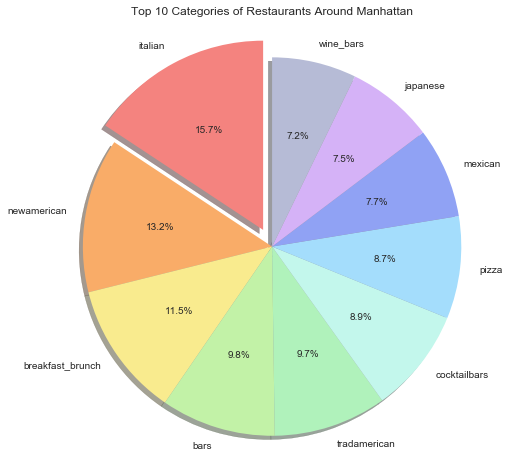

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
name_x = name[:10]
count_y = count[:10]
count_y = np.array(count_y)
sizes = np.round((count_y / np.sum(count_y) *100),2)
sizes = list(sizes)
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # only "explode" the 1nd slice (italian)
colors = ['#f4837f','#f9ac68','#f9eb8e','#c2f2a7','#b0f2bb','#c3f7ec','#a4ddfc','#90a2f4','#d5b2f7','#b6bbd6']

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=name_x, autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Top 10 Categories of Restaurants Around Manhattan')
plt.show()

### 2. Restaurants By Ratings

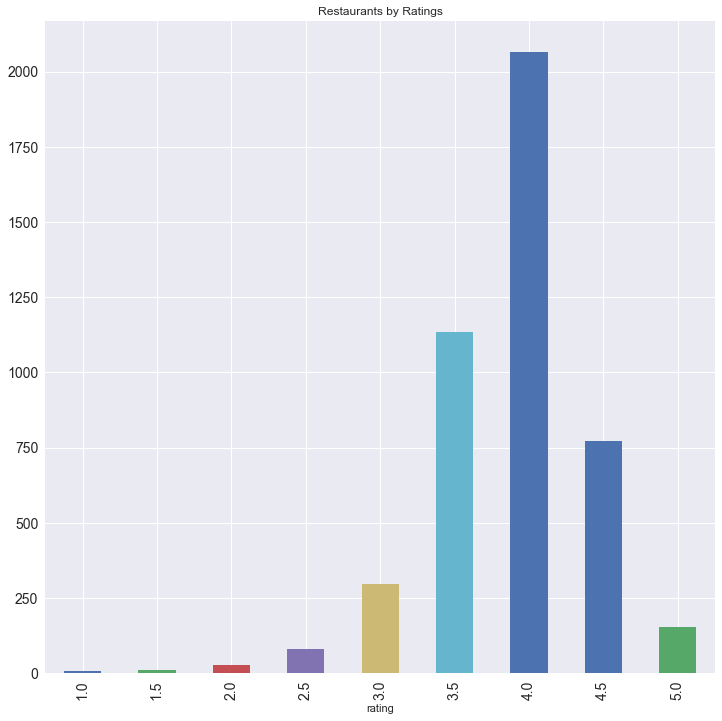

In [31]:
business.groupby('rating').size().plot(kind='bar',title="Restaurants by Ratings",figsize=(12,12),fontsize=14)


### 3. Restaurants By Price

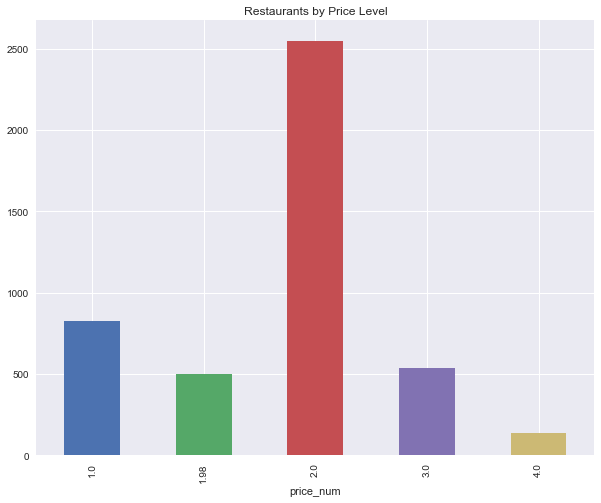

In [32]:
business.groupby('price_num').size().plot(kind='bar',title="Restaurants by Price Level",figsize=(10,8))

In [35]:
business.groupby('price_num').size()

price_num
1.00     827
1.98     503
2.00    2547
3.00     535
4.00     135
dtype: int64

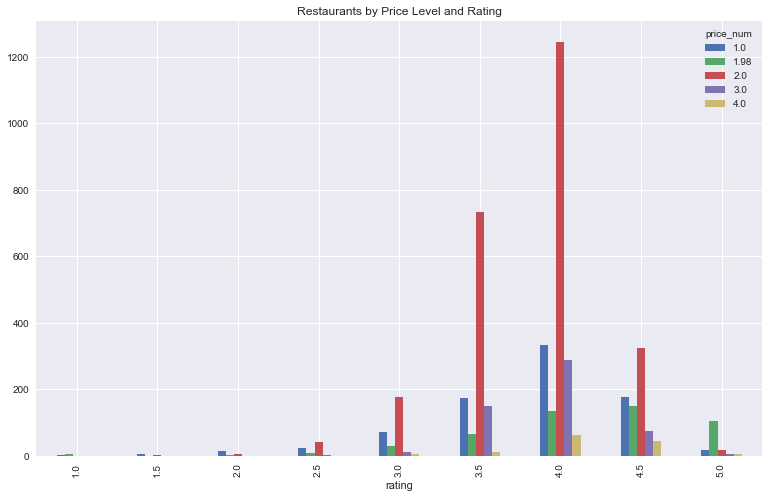

In [22]:
groups = business.groupby(['rating','price_num']).size().unstack()
groups.plot(kind='bar',title="Restaurants by Price Level and Rating",figsize=(13,8))

In [23]:
# More expensive restaurants does not mean they have higher ratings
# $$$$ price restaurant has in general great ratings, 4.0+
#.....

### 4. Restaurants By Distance Group

In [24]:
business.distance.describe()
min_dist = min(business.distance)
max_dist = max(business.distance)
print(f'Minimum distance from the pin is {min_dist} meters.\n'
      f'Maximum distance from the pin is {max_dist} meters.')

Minimum distance from the pin is 24.487955255017656 meters.
Maximum distance from the pin is 7082.122941502259 meters.



#### Rearrange distance into distance groups
#### Group1: 0-1000 m, Group2: 1000-2000m, Group3: 2000-3000 m, Group4: 3000-4000 m
#### Group5: 4000-5000m, Group6: 5000-6000 m, Group7: 6000-7000 m, Group8: 7000-8000 m,

In [25]:
def group_dist(x):
    if 0 <= x < 1000: return '0-1000m'
    elif 1000 <= x < 2000: return '1000-2000m'
    elif 2000 <= x < 3000: return '2000-3000m'
    elif 3000 <= x < 4000: return '3000-4000m'
    elif 4000 <= x < 5000: return '4000-5000m'
    elif 5000 <= x < 6000: return '5000-6000m'
    elif 6000 <= x < 7000: return '6000-7000m'
    else: return '7000-8000m'
business['dist_group'] = business['distance'].apply(lambda x: group_dist(x))

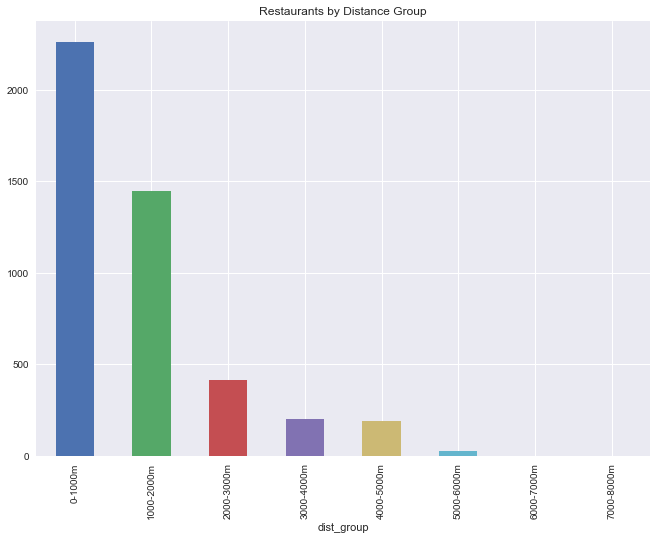

In [26]:
business.groupby('dist_group').size().plot(kind='bar',title="Restaurants by Distance Group",figsize=(11,8))

### 5. Restaurants By Transaction Services Providing

In [27]:
#business_pickup = business[business['pickup'] == True]
#business_pickup

In [28]:
transactions = business.groupby(['delivery','pickup','restaurant_reservation']).size().unstack()
transactions

restaurant_reservation  False  True 
delivery pickup                     
False    False           1753     87
         True              65     13
True     False             49      2
         True            2351    227

In [29]:
# With price level
transactions = business.groupby(['delivery','pickup','restaurant_reservation','price_num']).size().unstack()
transactions

price_num                                1.00   1.98    2.00   3.00   4.00
delivery pickup restaurant_reservation                                    
False    False  False                   365.0  283.0   681.0  317.0  107.0
                True                      NaN    5.0    57.0   20.0    5.0
         True   False                    16.0    2.0    38.0    7.0    2.0
                True                      NaN    NaN    11.0    2.0    NaN
True     False  False                    13.0    6.0    28.0    2.0    NaN
                True                      NaN    NaN     1.0    NaN    1.0
         True   False                   432.0  197.0  1540.0  164.0   18.0
                True                      1.0   10.0   191.0   23.0    2.0

### 6. Possible Correlation between Ratings, Price and Review Numbers 

In [65]:
# NOT REALLY....
# ONLY if have pickup service, most likely have delivery service
corr = business[['rating', 'price_num', 'review_count', 'pickup','delivery','restaurant_reservation']].corr()
corr

,rating,price_num,review_count,pickup,delivery,restaurant_reservation
rating,1.000000,0.073506,-0.007816,-0.131503,-0.140656,0.052989
price_num,0.073506,1.000000,0.146671,-0.134158,-0.138210,0.081403
review_count,-0.007816,0.146671,1.000000,0.018777,0.019543,0.079557
pickup,-0.131503,-0.134158,0.018777,1.000000,0.941796,0.082368
delivery,-0.140656,-0.138210,0.019543,0.941796,1.000000,0.066655
restaurant_reservation,0.052989,0.081403,0.079557,0.082368,0.066655,1.000000


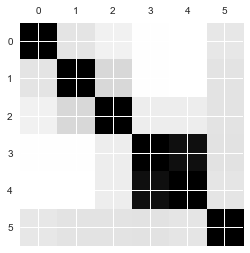

In [66]:
plt.matshow(corr)
plt.show()

## Choose 'Italian' Restaurant
#### From the general descriptives over 4000+ restaurants, we found 'italian' the most popular restaurant tag. 
#### This type of restaurant is the most popular one in Manhattan, so we choose to open a 'italian' type of restaurant

In [39]:
# Identify if a restaurant is newamerican or not
business['italian'] = business['categories'].apply(lambda x: 'italian' in x)

# Dataframe with only NewAmerican Restaurants
italian = business[business['italian'] == True]

In [40]:
italian

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,...,price_num,address,zip,latitude,longitude,pickup,delivery,restaurant_reservation,dist_group,italian
9,babbalucci-new-york,[italian],"{'latitude': 40.80894, 'longitude': -73.94496}",(646) 918-6572,531.822111,gyWc5qJRvu26LVQIShdR4Q,https://s3-media1.fl.yelpcdn.com/bphoto/3MOwPG...,False,"{'address1': '331 Lenox Ave', 'address2': '', ...",Babbalucci,...,2.00,"331 Lenox Ave, New York, NY 10027",10027,40.808940,-73.944960,True,True,False,0-1000m,True
10,pisticci-new-york,"[italian, breakfast_brunch]","{'latitude': 40.8141624, 'longitude': -73.960288}",(212) 932-3500,1140.188943,wZkZmjZEJDraLJgAalnHvA,https://s3-media1.fl.yelpcdn.com/bphoto/ERoh_M...,False,"{'address1': '125 La Salle St', 'address2': ''...",Pisticci,...,2.00,"125 La Salle St, New York, NY 10027",10027,40.814162,-73.960288,True,True,True,1000-2000m,True
15,vinatería-new-york-4,"[italian, spanish, seafood]","{'latitude': 40.8064392068585, 'longitude': -7...",(212) 662-8462,999.363229,MH08_pIRKsUSwfkVYxUE7w,https://s3-media2.fl.yelpcdn.com/bphoto/ZuDNNI...,False,"{'address1': '2211 Frederick Douglass Blvd', '...",VINATERÍA,...,2.00,"2211 Frederick Douglass Blvd, New York, NY 10026",10026,40.806439,-73.954011,False,False,False,0-1000m,True
24,sottocasa-pizzeria-harlem-new-york,"[pizza, italian]","{'latitude': 40.805587, 'longitude': -73.947547}",(646) 928-4870,888.573617,NPnWsPxOpG91GHx74S27Uw,https://s3-media1.fl.yelpcdn.com/bphoto/jttl7I...,False,"{'address1': '227 Lenox Ave', 'address2': '', ...",Sottocasa Pizzeria - Harlem,...,2.00,"227 Lenox Ave, New York, NY 10027",10027,40.805587,-73.947547,False,False,False,0-1000m,True
27,grazie-new-york-3,[italian],"{'latitude': 40.77948, 'longitude': -73.9601}",(212) 717-4407,3951.457366,_3QRn51W3IoqBzc9fYet4Q,https://s3-media1.fl.yelpcdn.com/bphoto/IIbqHx...,False,"{'address1': '26 E 84th St', 'address2': '', '...",Grazie,...,2.00,"26 E 84th St, New York, NY 10028",10028,40.779480,-73.960100,True,True,True,3000-4000m,True
35,lido-new-york,"[italian, breakfast_brunch, cocktailbars]","{'latitude': 40.8049797781916, 'longitude': -7...",(646) 490-8575,1170.550549,J9xVQScnr0lYWl61_mLXMA,https://s3-media4.fl.yelpcdn.com/bphoto/nlJAMT...,False,"{'address1': '2168 Frederick Douglass Blvd', '...",Lido,...,2.00,"2168 Frederick Douglass Blvd, New York, NY 10026",10026,40.804980,-73.954826,True,True,False,1000-2000m,True
42,fumo-pizza-bar-pasta-new-york-3,"[pizza, italian, bars]","{'latitude': 40.821442, 'longitude': -73.9506357}",(646) 692-6675,937.057594,V6e4UBjFzdrcUgKbJTrZpA,https://s3-media3.fl.yelpcdn.com/bphoto/P0peGT...,False,"{'address1': '1600 Amsterdam Ave', 'address2':...",Fumo Pizza-Bar-Pasta,...,2.00,"1600 Amsterdam Ave, New York, NY 10031",10031,40.821442,-73.950636,True,True,False,0-1000m,True
51,max-soha-new-york,[italian],"{'latitude': 40.811302, 'longitude': -73.958183}",(212) 531-2221,993.502933,vZ5-JXlJS75k8wmPNS5U5w,https://s3-media1.fl.yelpcdn.com/bphoto/BNvCZH...,False,"{'address1': '1274 Amsterdam Ave', 'address2':...",Max Soha,...,2.00,"1274 Amsterdam Ave, New York, NY 10027",10027,40.811302,-73.958183,True,True,False,0-1000m,True
61,raos-new-york,[italian],"{'latitude': 40.79392, 'longitude': -73.93427}",(212) 722-6709,2416.414975,zo4JHfD2nWPUiqgsgDOaHQ,https://s3-media2.fl.yelpcdn.com/bphoto/3orQwP...,False,"{'address1': '455 E 114th St', 'address2': Non...",Rao's,...,4.00,"455 E 114th St, New York, NY 10029",10029,40.793920,-73.934270,False,False,False,2000-3000m,True
65,patsys-pizzeria-new-york-7,"[pizza, italian]","{'latitude': 40.79713, 'longitude': -73.93481}",(212) 534-9783,2079.944811,Kh0-HmlgmVUkRxR55_Vn1g,https://s3-media1.fl.yelpcdn.com/bphoto/hx0TGZ...,False,"{'address1': '2287 1st Ave', 'address2': '', '...",Patsy's Pizzeria,...,2.00,"2287 1st Ave, New York, NY 10035",10035,40.797130,-73.934810,False,False,False,2000-3000m,True


### Save only Italian Restaurants to New Datafrae

In [42]:
italian.to_pickle("./italian_551.pkl")